In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import csv
import pandas as pd

In [1]:
def plot_prec_rec(df, thresholded = 0):
        mask= (df['thresholded?'] == thresholded)
        bins = pd.cut(df["threshold"], np.arange(0, 0.05, 0.001))

        df_by_iter = df[mask].groupby(['iteration', bins]).mean()[['precision','recall']]
        to_plot = df_by_iter.groupby(['threshold']).mean()
        to_plot[['prec_std', 'rec_std']] = df_by_iter.groupby(['threshold']).std()[['precision', 'recall']]
        to_plot['x'] = pd.IntervalIndex(to_plot.index.get_level_values('threshold')).mid
        to_plot = to_plot.reset_index().drop('threshold', axis=1)
        to_plot['prec_lower'] = to_plot.precision - 1.96*to_plot.prec_std
        to_plot['prec_upper'] = to_plot.precision + 1.96*to_plot.prec_std
        to_plot['rec_lower'] = to_plot.recall - 1.96*to_plot.rec_std
        to_plot['rec_upper'] = to_plot.recall + 1.96*to_plot.rec_std

        fig, ax = plt.subplots()
        ax.scatter(to_plot.x, to_plot.precision, color = 'blue', alpha = 0.5)
        ax.fill_between(to_plot.x, to_plot.prec_upper, to_plot.prec_lower, color='blue', alpha=.2)
        ax.scatter(to_plot.x, to_plot.recall, color = 'red', alpha = 0.5)
        ax.fill_between(to_plot.x, to_plot.rec_upper, to_plot.rec_lower, color='red', alpha=.2)
        x_rec_thr = to_plot.x[to_plot.recall<0.95].iloc[0]
        x_prec_thr = to_plot.x[to_plot.precision>0.3].iloc[0]

        ax.vlines(x = x_rec_thr,
                color = 'r',
                ymin = to_plot.rec_lower[to_plot.x == x_rec_thr],
                ymax = to_plot.rec_upper[to_plot.x == x_rec_thr],
                linestyles='-.')

        ax.vlines(x = x_prec_thr,
                color = 'b',
                ymin = to_plot.prec_lower[to_plot.x == x_prec_thr],
                ymax = to_plot.prec_upper[to_plot.x == x_prec_thr],
                linestyles='-.')

        print(f"Precision is above 0.3 with threshold above {100*x_prec_thr :.2f}%")
        print(f"Recall is above 0.95 with threshold below {100*x_rec_thr :.2f}%")
        print(f"Gap to bridge is  {x_prec_thr -x_rec_thr:.3f}")
        print(f"Recall at precision threshold is above {to_plot.recall[to_plot.x == x_prec_thr].iloc[0]:.2f}")

Precision is above 0.3 with threshold above 0.15%
Recall is above 0.95 with threshold below 0.15%
Gap to bridge is  0.000
Recall at precision threshold is above 0.89


/opt/anaconda/envs/tf/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


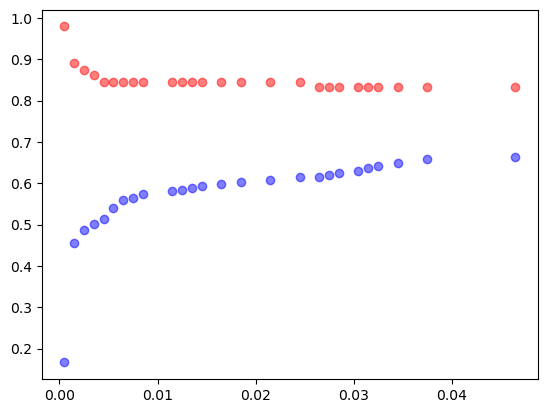

In [4]:
df = pd.read_csv('B5_prec_rec_finetuned.csv', delimiter='\t')
plot_prec_rec(df, 0)

In [5]:
errors_df = pd.read_csv('B5_errors_finetuned.csv', delimiter='\t')
errors_df = errors_df.groupby(['name']).sum().sort_values('true', ascending=False)
errors_df.head(20)

,iteration,true,pred
name,,,
8e5f221988e621599a66b4295d11cd96-79-1.jpg,0,1,0
dccf1d01b546dfbdf4b1792431ced1cb-192-1.jpg,0,1,0
8e5f221988e621599a66b4295d11cd96-293-1.jpg,0,1,0
99a2b4a3f0e110765f489bbcaa97eaba-147-1.jpg,0,1,0
a22b8489132c79f58415f48d3e911b00-96-2.jpg,0,1,0
7c689131cd8b4692c18e38a35ebfe5bc-124-1.jpg,0,1,0
7c09b8e55c2f67a1feb91c6b5b6c25ec-126-1.jpg,0,1,0
b393e6b86ed4f6cb542df41fe298b5e0-98-1.jpg,0,1,0
43191236f6725e80c464e05801068bd7-293-1.jpg,0,1,0


In [6]:
fn = errors_df['true'].sum()
fp = errors_df['pred'].sum()
p = 90
tp = p-fn
rec = tp/p
prec = tp/(tp+fp)
print("On validation dataset finetuned B5 at threshold 0.5%:")
print(f"fp: {fp}   fn:{fn}   rec:{100*rec:.1f}%   prec:{100*prec:.1f}%")

On validation dataset finetuned B5 at threshold 0.5%:
fp: 68   fn:14   rec:84.4%   prec:52.8%
